In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import rasterio
import torch
from GLC23Datasets import RGNIR_env_Dataset
from models import twoBranchCNN
from tqdm import tqdm

In [2]:
batch_size = 64
learning_rate = 1e-3
n_epochs = 100
bin_thresh = 0.1

In [3]:
data_path = 'data/full_data/'
presence_absence_path = data_path+'Presence_Absence_surveys/Presences_Absences_train.csv'

presence_absence_df = pd.read_csv(presence_absence_path, sep=";", header='infer', low_memory=False)
sorted_patches = presence_absence_df.drop_duplicates(['patchID','dayOfYear']).sort_values(['lat','lon'])
    
n_val = round(sorted_patches.shape[0] * 0.2)
val_patches = sorted_patches.iloc[0:n_val] 
val_presence_absence = presence_absence_df[(presence_absence_df['patchID'].isin(val_patches['patchID'])) &
                                           (presence_absence_df['dayOfYear'].isin(val_patches['dayOfYear']))].reset_index(drop=True)
print(f"Validation set: {n_val} patches -> {val_presence_absence.shape[0]} observations")
train_patches = sorted_patches.iloc[n_val:]
train_presence_absence = presence_absence_df[(presence_absence_df['patchID'].isin(train_patches['patchID'])) &
                                             (presence_absence_df['dayOfYear'].isin(train_patches['dayOfYear']))].reset_index(drop=True)
print(f"Training set: {train_patches.shape[0]} patches -> {train_presence_absence.shape[0]} observations")

train_dataset = RGNIR_env_Dataset(train_presence_absence, env_patch_size=10, rgbnir_patch_size=100)
n_species = len(train_dataset.species)
print(f"Training set: {len(train_dataset)} sites, {n_species} sites")
val_dataset = RGNIR_env_Dataset(val_presence_absence, species=train_dataset.species, env_patch_size=10, rgbnir_patch_size=100)
print(f"Validation set: {len(val_dataset)} sites, {len(val_dataset.species)} sites")

Validation set: 1190 patches -> 18758 observations
Training set: 4758 patches -> 66567 observations
Training set: 6248 sites, 1730 sites
Validation set: 1190 sites, 1730 sites


In [4]:
model = twoBranchCNN(n_species)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)#, momentum=0.9)
loss_fn = torch.nn.BCEWithLogitsLoss() 

run_name = '24_dataset_from_scratch'
print("\nLoading best train loss model checkpoint...")
checkpoint = torch.load(f"models/{run_name}/best_train_loss.pth")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
print(f"model checkpoint at epoch {epoch}")


Loading best train loss model checkpoint...
model checkpoint at epoch 199


In [5]:
submission = pd.read_csv("data/test_blind.csv", sep=';')
submission

,Id,datasetName,date,dayOfYear,year,patchID,timeSerieID,lon,lat,x_EPSG3035,y_EPSG3035,geoUncertaintyInM
0,1,CBNMed,1629064800,228,2021,10125,3988380,1.729607,42.52171,3.640762e+06,2.194746e+06,5.0
1,2,CBNMed,1629064800,228,2021,10126,3997090,1.729624,42.52177,3.640764e+06,2.194753e+06,4.0
2,3,CBNMed,1629064800,228,2021,10127,4001106,1.729652,42.52197,3.640769e+06,2.194775e+06,5.0
3,4,CBNMed,1629064800,228,2021,10129,4004605,1.729671,42.52192,3.640770e+06,2.194769e+06,6.0
4,5,CBNMed,1531346400,193,2018,10154,3987660,1.826847,42.57452,3.649316e+06,2.199695e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
22399,22400,Inventaire forestier IGN,2018-03-14,73,2018,3018864,3990152,9.421020,42.38755,4.273164e+06,2.142680e+06,1.0
22400,22401,Inventaire forestier IGN,2018-03-22,81,2018,3018865,3986840,9.429860,42.26077,4.273796e+06,2.128639e+06,1.0
22401,22402,Inventaire forestier IGN,2017-03-13,72,2017,3018866,3993669,9.462680,42.92578,4.277004e+06,2.202255e+06,1.0
22402,22403,Inventaire forestier IGN,2017-03-15,74,2017,3018867,3993567,9.497790,42.41844,4.279528e+06,2.146054e+06,1.0


In [6]:
submission_dataset = RGNIR_env_Dataset(submission, species=train_dataset.species, env_patch_size=10, rgbnir_patch_size=100, label_col='Id')
print(f"SUBMISSION DATA: {len(submission_dataset)}")
submission_loader = torch.utils.data.DataLoader(submission_dataset, shuffle=False, batch_size=batch_size, num_workers=24)

SUBMISSION DATA: 22404


In [7]:
y_pred_list = []
for rgb, env, _ in tqdm(submission_loader):
    batch_y_pred = torch.sigmoid(model(rgb.to(torch.float32), env.to(torch.float32)))
    y_pred_list.append(batch_y_pred.cpu().detach().numpy())

100%|██████████| 351/351 [00:41<00:00,  8.44it/s]


In [12]:
best_threshold = 0.1
y_pred = np.concatenate(y_pred_list)
y_bin = np.where(y_pred > best_threshold, 1, 0)
y_pred.shape

(22404, 1730)

In [11]:
targets = train_dataset.species
targets

array([    5,    10,    11, ..., 10035, 10038, 10039])

In [13]:
pred_species = [' '.join([str(x) for x in targets[np.where(y_pred[i, :] > best_threshold)]]) for i in range(y_pred.shape[0])]
sub_df = pd.DataFrame({'Id': submission.Id, 'Predicted': pred_species})
sub_df

,Id,Predicted
0,1,386 515 1005 2509 3069 4284 5314 5763 5959 683...
1,2,386 515 1005 2509 3069 4284 5314 5763 5959 683...
2,3,386 515 1005 2509 3069 4284 5314 5763 5959 683...
3,4,386 515 1005 2509 3069 4284 5314 5763 5959 683...
4,5,386 515 1005 1662 2509 3069 3833 4284 5314 576...
...,...,...
22399,22400,386 515 1005 2509 4284 5314 5763 5959 6837 893...
22400,22401,24 386 515 795 801 1005 1662 2509 3069 3833 42...
22401,22402,386 515 795 1005 1662 1849 2509 3069 4284 5314...
22402,22403,386 515 1005 2509 3069 4284 5314 5959 6837 893...


In [ ]:
sub_df.to_csv(f"data/submissions/{run_name}_submission_epoch_{epoch}_thresh_{str(best_threshold)}.csv", index=False)

In [ ]:
 
    # print("Making predictions on submission data...")
    # y_pred_list = []
    # for rgb, env, labels in tqdm(submission_loader):
    #         batch_y_pred = torch.sigmoid(model(rgb.to(torch.float32).to(dev), env.to(torch.float32).to(dev)))
    #         y_pred_list.append(batch_y_pred.cpu().detach().numpy())

    # targets = train_data.sorted_unique_targets
    # y_pred = np.concatenate(y_pred_list)
    # 
    # np.save(f"models/{run_name}/submission_y_pred_epoch_{str(epoch)}_thresh_{str(best_threshold)}.npy", y_pred)
    # np.save(f"models/{run_name}/target.npy", targets)

    # pred_species = [' '.join([str(x) for x in targets[np.where(y_pred[i, :] > best_threshold)]]) for i in range(y_pred.shape[0])]
    # sub_df = pd.DataFrame({'Id': submission.Id, 'Predicted': pred_species})
    # sub_df.to_csv(f"data/submissions/{run_name}_submission_epoch_{epoch}_thresh_{str(best_threshold)}.csv", index=False)

In [2]:
data_path = 'data/full_data/'
presence_only_path = data_path+'Presence_only_occurrences/Presences_only_train_sampled_100.csv'
presence_absence_path = data_path+'Presence_Absence_surveys/Presences_Absences_train.csv'

In [3]:
presence_only_df = pd.read_csv(presence_only_path, sep=";", header='infer', low_memory=False)
presence_only_df.shape

(410899, 16)

In [4]:
presence_absence_df = pd.read_csv(presence_absence_path, sep=";", header='infer', low_memory=False)
presence_absence_df.shape

(85325, 15)

In [5]:
from GLC23Datasets import RGNIR_env_Dataset

In [11]:
dataset = RGNIR_env_Dataset(presence_absence_df)
len(dataset)

7438

In [13]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=2)

In [14]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=2)
for rgb, env, labels in dataloader:
    print(rgb.shape, env.shape, labels.shape)
    break

torch.Size([2, 4, 128, 128]) torch.Size([2, 21, 128, 128]) torch.Size([2, 2174])


In [8]:
dataset[0][1].shape

(21, 128, 128)

In [9]:
dataset[0][2].shape

(2174,)

In [7]:
sites = presence_only_df[['patchID','dayOfYear','lat','lon']].drop_duplicates().reset_index(drop=True)
sites

,patchID,dayOfYear,lat,lon
0,3019043,144,52.18669,-10.189970
1,3019093,221,51.74629,-10.133990
2,3019203,183,53.43000,-10.045470
3,3019293,185,53.39348,-9.993714
4,3019345,45,52.07664,-9.968167
...,...,...,...,...
392903,4731159,120,45.64443,5.869271
392904,4323236,310,51.33690,4.305170
392905,3613216,333,47.45600,-0.595808
392906,4457741,242,52.38190,4.769210


In [8]:
species = presence_only_df['speciesId'].sort_values().unique()
species

array([    1,     2,     3, ..., 10037, 10038, 10039])

In [9]:
index = 55#16
item = sites.iloc[index].to_dict()
item

{'patchID': 3020712.0, 'dayOfYear': 197.0, 'lat': 38.80892, 'lon': -9.480447}

In [10]:
item_species = presence_only_df[
    (presence_only_df['patchID'] == item['patchID']) & (presence_only_df['dayOfYear'] == item['dayOfYear'])
].speciesId.values
print(item_species)
labels = 1 * np.isin(species, item_species)
print(labels.sum(), 'species')

[1586]
1 species


In [11]:
size = 20

In [12]:
#jpeg patch provider

def crop_img(img, size):
    xmin=round((img.shape[0] - size) /2)
    xmax=round((img.shape[0] + size) /2)
    ymin=round((img.shape[1] - size) /2)
    ymax=round((img.shape[1] + size) /2)
    img = img[xmin:xmax, ymin:ymax]
    return img

list_tensor = {'order': [], 'tensors':[]}

#patchID=3018575 is "./rgb/75/85/3018575.jpeg". I
id_ = str(int(item['patchID']))

rgb_path = f"data/full_data/SatelliteImages/rgb/{id_[-2:]}/{id_[-4:-2]}/{id_}.jpeg"
img = np.asarray(Image.open(rgb_path))
img = img / 255.0

for i, channel in enumerate(['red','green','blue']):
    channel_img = img[:,:,i]
    if size < 128: 
        channel_img = crop_img(channel_img, size)
    list_tensor['tensors'].append(np.expand_dims(channel_img, axis=0))
    list_tensor['order'].append(channel)

nir_path = f"data/full_data/SatelliteImages/nir/{id_[-2:]}/{id_[-4:-2]}/{id_}.jpeg"
nir_img = np.array(Image.open(nir_path))
if size < 128: 
    nir_img = crop_img(nir_img, size)
list_tensor['tensors'].append(np.expand_dims(nir_img,axis=0))
list_tensor['order'].append('nir')
tensor = np.concatenate(list_tensor['tensors'])
print(tensor.shape)

(4, 20, 20)


In [13]:
size = 20
rgb_path = f"data/full_data/SatelliteImages/rgb/{id_[-2:]}/{id_[-4:-2]}/{id_}.jpeg"
rgb_img = (np.asarray(Image.open(rgb_path)) / 255.0).transpose((2,0,1))
rgb_img.shape

nir_path = f"data/full_data/SatelliteImages/nir/{id_[-2:]}/{id_[-4:-2]}/{id_}.jpeg"
nir_img = np.expand_dims(np.asarray(Image.open(nir_path)) / 255.0, axis=0)
nir_img.shape

img = np.concatenate([rgb_img, nir_img])
print(img.shape)

(4, 128, 128)


In [14]:
xmin=round((img[0].shape[0] - size) /2)
xmax=round((img[0].shape[0] + size) /2)
ymin=round((img[0].shape[1] - size) /2)
ymax=round((img[0].shape[1] + size) /2)
img = img[:, xmin:xmax, ymin:ymax]
img.shape

(4, 20, 20)

In [15]:
img = np.concatenate([rgb_img, nir_img])
img.shape

(4, 128, 128)

In [34]:
layer_stats = {}

env_dirs=["data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/", "data/full_data/EnvironmentalRasters/HumanFootprint/summarized/"]

for subdir in env_dirs:
    print(subdir)
    for file in os.listdir(subdir):
        if ".tif" not in file: continue
        path = subdir + file

        with rasterio.open(path) as src:
            n = src.count
            assert n == 1, f"number of layers should be 1, for {subdir+file} got {n}"
            nodata_value = src.nodatavals[0]
            data = src.read().astype(float)
            data = np.where(data == nodata_value, np.nan, data)
            layer_stats[subdir + file] = {'mean': np.nanmean(data), 'std': np.nanstd(data), 'min': np.nanmin(data), 'max': np.nanmax(data), 'nodata_value': nodata_value}

data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/
data/full_data/EnvironmentalRasters/HumanFootprint/summarized/


In [35]:
len(layer_stats)

21

In [36]:
layer_stats

{'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio9.tif': {'mean': 2855.18183804263,
  'std': 106.85082954009508,
  'min': 2491.0,
  'max': 3110.0,
  'nodata_value': 65535.0},
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio8.tif': {'mean': 2845.0932405655067,
  'std': 67.71531181071403,
  'min': 2395.0,
  'max': 3056.0,
  'nodata_value': 65535.0},
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio7.tif': {'mean': 180.29882008269908,
  'std': 98.33137477288932,
  'min': 0.0,
  'max': 403.0,
  'nodata_value': None},
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio6.tif': {'mean': 2755.297967210001,
  'std': 106.67433596061956,
  'min': 0.0,
  'max': 2929.0,
  'nodata_value': None},
 'data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio5.tif': {'mean': 2935.5967872927,
  'std': 106.62718829585059,
  'min': 0.0,
  'max': 3190.0,
  'nodata_value':

In [44]:
patch_list = []
for rasterpath, stats in layer_stats.items():
    with rasterio.open(rasterpath) as src:
        center_x, center_y = src.index(item['lon'], item['lat'])
        left = center_x - (size // 2)
        top = center_y - (size // 2)
        patch = src.read(window=rasterio.windows.Window(left, top, size, size)).astype(float)
        # print(patch.shape, patch[0,0:3,0:3])
        # patch[i] = (patch[i] - layer_stats[i][0]) / layer_stats[i][1] # standard scaling
        patch = (patch - stats['min']) / (stats['max'] - stats['min']) # min max scaling
        # print(patch.shape, patch[0,0:3,0:3])
        patch_list.append(patch)

env_patch = np.concatenate(patch_list)
env_patch.shape

(21, 20, 20)

In [68]:
# raster patch provider get item
with rasterio.open(path) as src:
    center_x, center_y = src.index(item['lon'], item['lat'])
    left = center_x - (size // 2)
    # right = center_x + (patch_size // 2)
    top = center_y - (size // 2)
    # bottom = center_y + (patch_size // 2)
    patch = src.read(window=rasterio.windows.Window(left, top, size, size)).astype(float)
    for i in range(nb_layers):
        # patch[i] = (patch[i] - layer_stats[i][0]) / layer_stats[i][1] # standard scaling
        patch[i] = (patch[i] - layer_minmax[i][0]) / (layer_minmax[i][1] - layer_minmax[i][0]) # min max scaling

patch.shape

(1, 20, 20)

In [66]:
# multi raster patch provider 
bioclim_path = f"data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/"
for file in os.listdir(bioclim_path):
    if ".tif" not in file: continue
    path = bioclim_path + file
    print(path)


data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio9.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio8.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio7.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio6.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio5.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio4.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio3.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio2.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio19.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio18.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio17.tif
data/full_data/EnvironmentalRasters/Climate/BioClimatic_Average_1981-2010/bio16.tif


In [59]:
patch.shape

(1, 20, 20)

In [37]:
import matplotlib.pyplot as plt

[2794. 2836. 2906.]
(4005, 2734)
4005 2734


Text(4000, 2000, 'here glc')

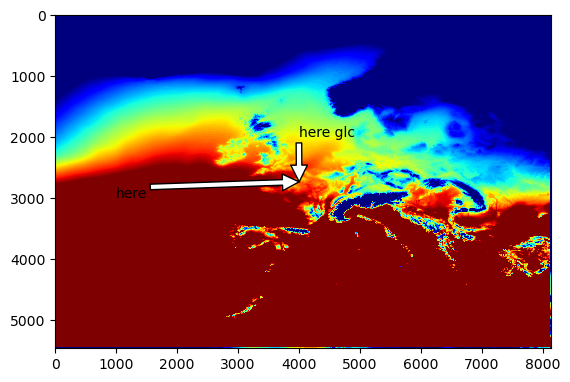

In [38]:
src = rasterio.open(path)
data = src.read(1)
print(np.quantile(data.flatten(), [0.25, 0.5, 0.75]))
fig, ax = plt.subplots()
ax.imshow(data, cmap='jet', vmin=2790, vmax=2850)

#rasterio method
print(src.index(item['lon'], item['lat']))
ax.annotate('here', xy=(src.index(item['lon'], item['lat'])), xytext=(1000, 3000), arrowprops=dict(facecolor='white', shrink=0.0005),)

#glc method
x = int(src.height - (item['lat'] - src.bounds.bottom) / src.res[1])
y = int((item['lon'] - src.bounds.left) / src.res[0])
print(x,y)
ax.annotate('here glc', xy=(x, y), xytext=(4000, 2000), arrowprops=dict(facecolor='white', shrink=0.0005),)


In [92]:
print(src.bounds)
center_x, center_y = src.index(item['lon'], item['lat'])
print(center_x, center_y)
#lat': 40.7175, 'lon': -3.856685}

BoundingBox(left=-32.266806146449994, bottom=26.63319397795, right=35.591526915450004, top=72.19152712905)
2452 2724


In [165]:
with rasterio.open(path) as src:
    x,y = rasterio.transform.rowcol(src.transform, item['lon'], item['lat'])
    data = src.read(1)
    data = src.read(1, index=(x,y))
    print(x,y)
    print(data[x,y])

TypeError: read() got an unexpected keyword argument 'index'

In [32]:
patch_size = 2000
with rasterio.open(path) as src:
    center_x, center_y = src.index(item['lon'], item['lat'])
    left = center_x - (patch_size // 2)
    right = center_x + (patch_size // 2)
    top = center_y - (patch_size // 2)
    bottom = center_y + (patch_size // 2)
    print(left, right, top, bottom)
    patch = src.read(1, window=rasterio.windows.Window(left, top, patch_size, patch_size))
    print(patch.shape)
    print(patch[10,10])
    print(np.quantile(patch.flatten(), [0.25, 0.5, 0.75]))
    plt.imshow(patch, cmap='jet', vmin=2790, vmax=2850)
    print(np.expand_dims(patch,axis=0).shape)

-962 1038 -1010 990
(128, 128)
91
[79. 90. 97.]


/home/nina/miniconda3/envs/glc23/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


NameError: name 'plt' is not defined

5467 8143
0.0083333333 0.0083333333
-32.266806146449994 26.63319397795
1734 3734 3005 5005
(1, 2000, 2000)
[2825]
[2827. 2836. 2855.]


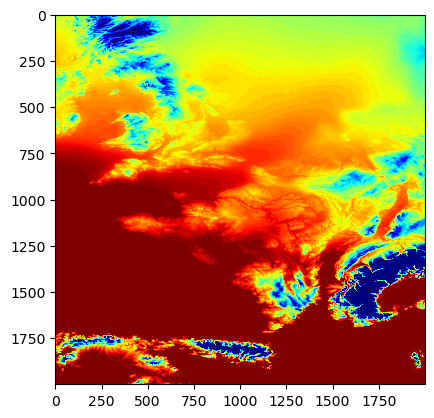

In [199]:
patch_size = 2000
with rasterio.open(path) as src:
    n_rows = src.height
    n_cols = src.width
    print(n_rows, n_cols)
    x_resolution = src.res[0]
    y_resolution = src.res[1]
    print(x_resolution, y_resolution)
    x_min = src.bounds.left
    y_min = src.bounds.bottom
    print(x_min, y_min)

    y = int(n_rows - (item['lat'] - y_min) / y_resolution)
    x = int((item['lon'] - x_min) / x_resolution)

    data = src.read()
    print(x - (patch_size // 2), x + (patch_size // 2), y - (patch_size // 2), y + (patch_size // 2))
    patch = data[:, x - (patch_size // 2): x + (patch_size // 2), y - (patch_size // 2): y + (patch_size // 2)]
    print(patch.shape)
    print(patch[:,10,10])
    print(np.quantile(patch.flatten(), [0.25, 0.5, 0.75]))
    plt.imshow(patch[0], cmap='jet', vmin=2790, vmax=2850)

    #left right top bottom
    #2776 4776 2409 4409



In [34]:
src.bounds

BoundingBox(left=-32.266806146449994, bottom=26.63319397795, right=35.591526915450004, top=72.19152712905)

In [31]:
src.transform

Affine(0.0083333333, 0.0, -32.266806146449994,
       0.0, -0.0083333333, 72.19152712905)